In [1]:
%cd ../
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython import display


c:\Users\Derrick\Desktop\Github\Machine_Learning


In [18]:
nPerClass = 1000
imgSize   = 111

x = np.linspace(-5,5,imgSize)
X,Y = np.meshgrid(x,x)

widths = [2, 3]

images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

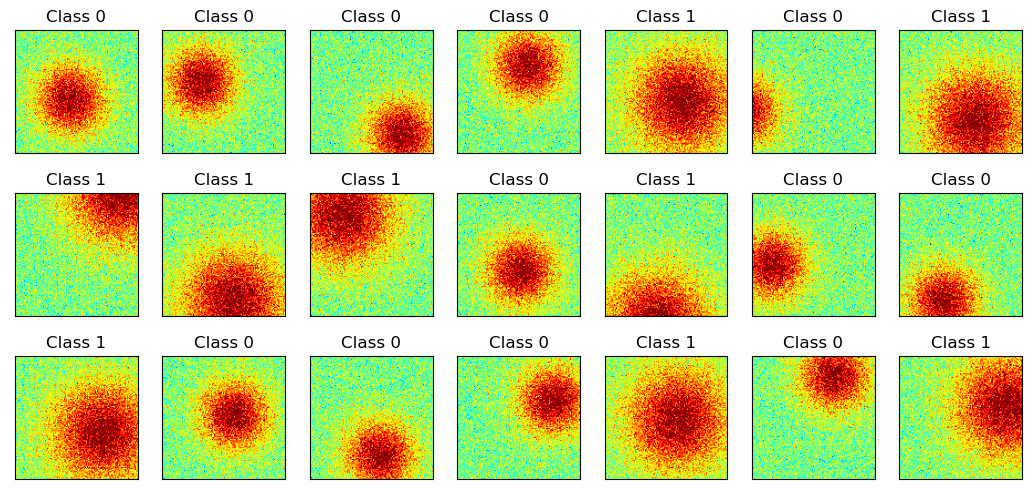

In [19]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [20]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [21]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 111, 111])
torch.Size([1800, 1])
torch.Size([200, 1, 111, 111])
torch.Size([200, 1])


In [24]:
def create_model():
    class model(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Flatten(),
                nn.Linear(27*27*4,50),
                nn.Linear(50,1)
            )

        def forward(self, x):
            return self.enc(x)

    net = model()
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)
    return net, loss_fun, optimizer


In [26]:
def train_model():
    EPOCHS = 10

    net, loss_fun, optimizer = create_model()

    train_loss = torch.zeros(EPOCHS)
    test_loss = torch.zeros(EPOCHS)
    train_acc = torch.zeros(EPOCHS)
    test_acc = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        batch_loss = []
        batch_acc = []
        for X, y in train_loader:
            y_hat = net(X)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((y_hat>0).float()).item())

            train_loss[i] = np.mean(batch_loss)
            train_acc[i] = 100 * np.mean(batch_acc)

            X, y = next(iter(test_loader))
            with torch.inference_mode():
                y_hat = net(X)
                loss =loss_fun(y_hat, y)

            test_loss[i] = loss.item()
            test_acc[i] = 100 * torch.mean(((y_hat>0)==y).float()).item()

    return train_loss, test_loss, train_acc, test_acc, net

train_loss, test_loss, train_acc, test_acc, net = train_model()

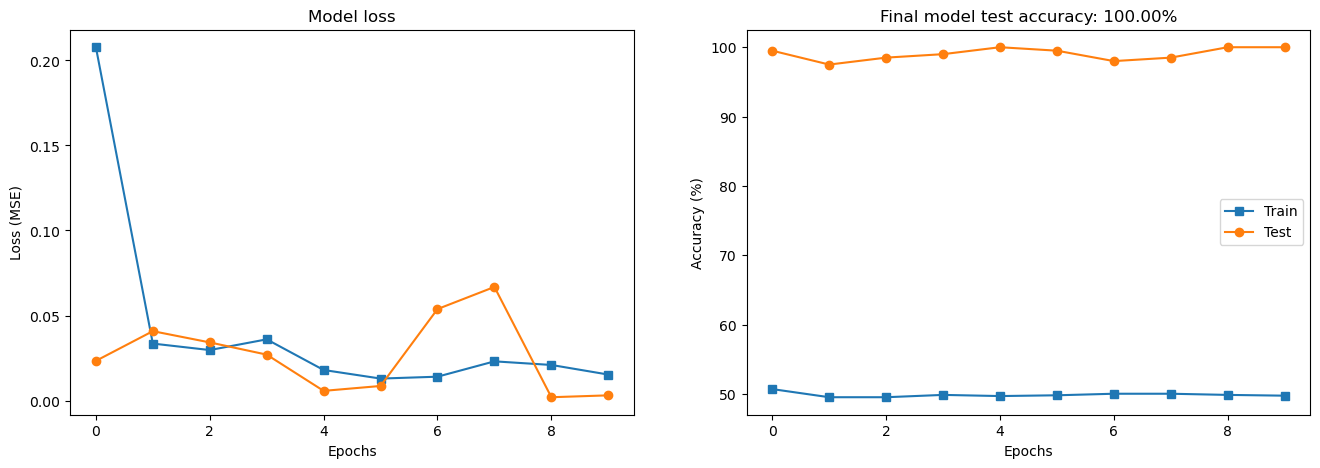

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(test_loss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(test_acc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

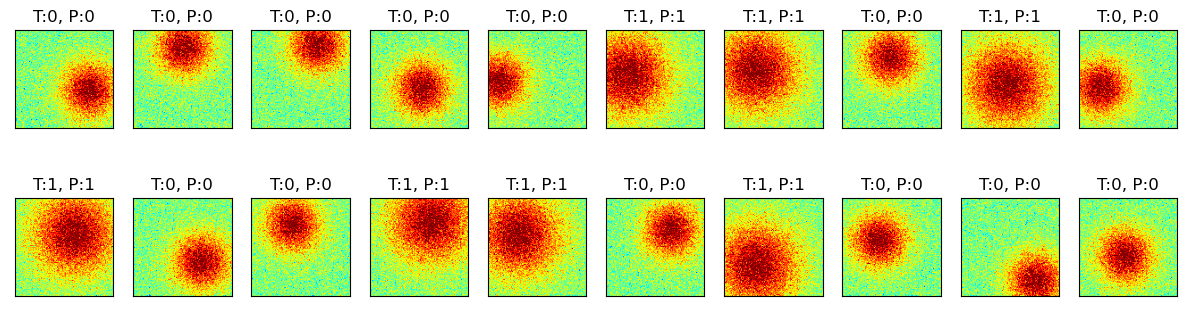

In [28]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [29]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

model(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2916, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


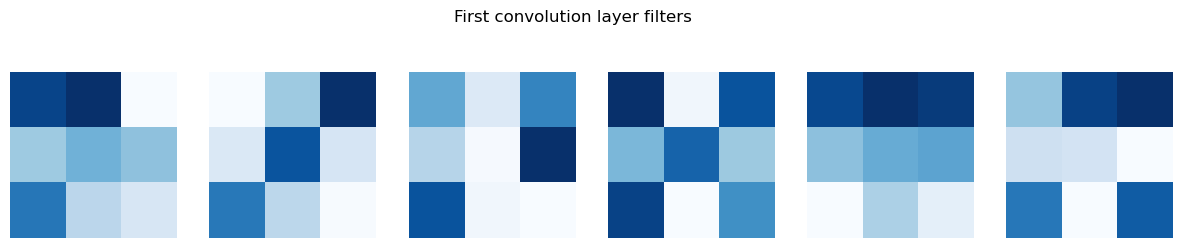

In [38]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Blues')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

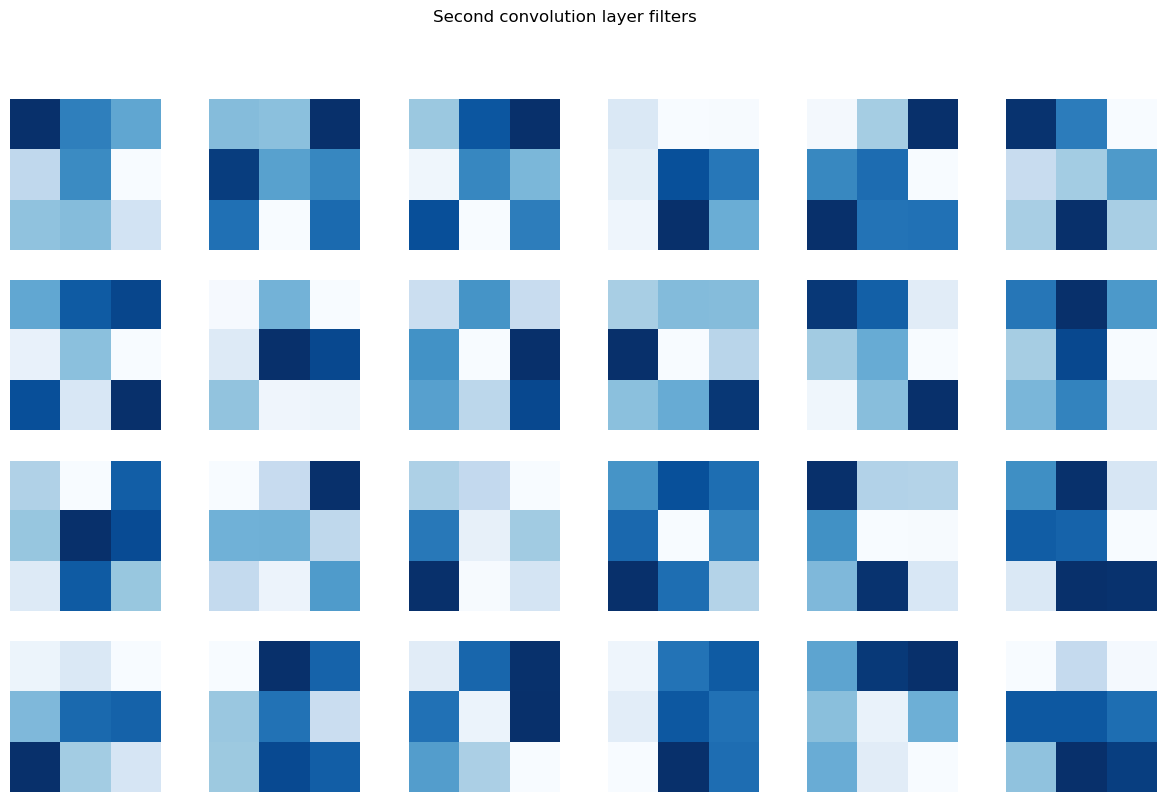

In [39]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Blues')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()